<a href="https://colab.research.google.com/github/stwind/notebooks/blob/master/neural_ca_textures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
!pip install -Uq torchinfo

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import io
import os
import math
import time
import random
import requests
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import PIL
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as tfms
import torchvision.models as models
import moviepy.editor as mvp
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
from torchinfo import summary
from fastprogress.fastprogress import progress_bar
from matplotlib.gridspec import GridSpec
from IPython.display import Image, HTML, clear_output
from moviepy.editor import VideoClip
from PIL import ImageDraw

os.environ['FFMPEG_BINARY'] = 'ffmpeg'

sns.set('notebook', 'darkgrid', rc={
    'font.family': ['DejaVu Sans'],
    'font.sans-serif': ['Open Sans', 'Arial Unicode MS'],
    'font.size': 12,
    'figure.figsize': (8, 5),
    'grid.linewidth': 1,
    'grid.alpha': 0.5,
    'legend.fontsize': 10,
    'legend.frameon': True,
    'legend.framealpha': 0.6,
    'legend.handletextpad': 0.2,
    'lines.linewidth': 1,
    'axes.facecolor': '#fafafa',
    'axes.labelsize': 11,
    'axes.titlesize': 12,
    'axes.linewidth': 0.5,
    'xtick.labelsize': 11,
    'xtick.major.width': 0.5,
    'ytick.labelsize': 11,
    'ytick.major.width': 0.5,
    'figure.titlesize': 13,
})
plt.style.use("dark_background")

print("Infos:")
print("numpy: {}".format(np.__version__))
print("seaborn: {}".format(sns.__version__))
print("matplotlib: {}".format(mpl.__version__))
print("pytorch: {}".format(torch.__version__))
for i in range(torch.cuda.device_count()):
    print("cuda device #{}: {}".format(i, torch.cuda.get_device_name(i)))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("current device type: {}".format(device.type))

Infos:
numpy: 1.19.5
seaborn: 0.11.1
matplotlib: 3.2.2
pytorch: 1.7.0+cu101
cuda device #0: Tesla T4
current device type: cuda


## Utils

In [3]:
def fetch_image(url, size=128, mode=None):
    if url.startswith(('http:', 'https:')):
        r = requests.get(url)
        f = io.BytesIO(r.content)
    else:
        f = url
    img = PIL.Image.open(f)
    if size is not None:
        img.thumbnail((size, size), PIL.Image.ANTIALIAS)
    if mode is not None:
        img = img.convert(mode)
    return img

def imshow(img, figsize=(5,5), title=None):
    plt.figure(figsize=figsize)
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.show()

## Model

In [5]:
IMAGE_SIZE = 128
CHANNEL_N = 12
HIDDEN_N = 96

def make_seed(n=1, c=CHANNEL_N, h=IMAGE_SIZE, w=IMAGE_SIZE):
    return torch.zeros(n, c, h, w)

### CA

In [6]:
def padding_same(in_size, kernel_size, stride=1, dilation=1):
    filter_size = (kernel_size - 1) * dilation + 1
    out_size = (in_size + stride - 1) // stride
    return max(0, (out_size - 1) * stride + filter_size - in_size)


def pad_same(x, kernel_size, stride=1, mode='constant'):
    """same behavior as padding='SAME' of tensorflow"""
    _, _, h, w = x.size()
    kh, kw = (kernel_size, kernel_size) if isinstance(kernel_size, int) else kernel_size
    sh, sw = (stride, stride) if isinstance(stride, int) else stride
    ph, pw = padding_same(h, kh, sh), padding_same(w, kw, sw)
    hph, hpw = ph // 2, pw // 2
    return F.pad(x, [hpw, hpw + (pw % 2), hph, hph + (ph % 2)], mode=mode)


def depthwise_conv2d(x, kernel, stride=1, dilation=1):
    """same behavior as tf.nn.depthwise_conv2d"""
    cout, cin, kh, kw = kernel.size()
    kernel = kernel.permute(1, 0, 2, 3).reshape(cout * cin, 1, kh, kw)
    return F.conv2d(x, kernel, groups=cin, stride=stride, dilation=dilation)


class NeuralCA(nn.Module):
    def __init__(self, channels=CHANNEL_N, hidden_n=HIDDEN_N):
        super().__init__()
        identity = torch.outer(torch.tensor([0.0, 1.0, 0.0]), torch.tensor([0.0, 1.0, 0.0]))
        sobel_x = torch.outer(torch.tensor([1., 2., 1.]), torch.tensor([-1., 0., 1.])) / 8.0
        lap = torch.tensor([[1.0,2.0,1.0],[2.0,-12,2.0],[1.0,2.0,1.0]]) / 16.0
        self.kernel = torch.stack([identity, sobel_x, sobel_x.T, lap],-1).unsqueeze(2).expand(-1,-1,channels,-1).permute(3,2,0,1)
        
        conv1 = nn.Conv2d(channels * 4, hidden_n, 1)
        conv2 = nn.Conv2d(hidden_n, channels, 1, bias=False)
        nn.init.zeros_(conv2.weight.data)
        self.dmodel = nn.Sequential(conv1, nn.ReLU(), conv2)
        
    def perceive(self, x):
        x = pad_same(x, 3, mode='circular')
        return depthwise_conv2d(x, self.kernel.to(x.device))

    def forward(self, x, thres=0.5):
        y = self.dmodel(self.perceive(x))
        mask = (torch.rand_like(y[:,:1,:,:]) + thres).floor()
        x += y * mask
        return x

nca = NeuralCA().to(device)
summary(nca, (1,CHANNEL_N,IMAGE_SIZE,IMAGE_SIZE), verbose=False)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [1, 12, 128, 128]         --
|    └─Conv2d: 2-1                       [1, 96, 128, 128]         4,704
|    └─ReLU: 2-2                         [1, 96, 128, 128]         --
|    └─Conv2d: 2-3                       [1, 12, 128, 128]         1,152
Total params: 5,856
Trainable params: 5,856
Non-trainable params: 0
Total mult-adds (M): 94.38
Input size (MB): 0.79
Forward/backward pass size (MB): 14.16
Params size (MB): 0.02
Estimated Total Size (MB): 14.97

### Style

In [7]:
vgg16 = models.vgg16(pretrained=True).features.eval().to(device)

In [8]:
MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])
normalize = tfms.Normalize(MEAN, STD)
denormalize = tfms.Normalize(-MEAN / STD, 1 / STD)

def calc_styles(x, layers=[1, 6, 11, 18, 25]):
    grams = []
    x = normalize(x)
    for i, layer in enumerate(vgg16[:max(layers)+1]):
        x = layer(x)
        if i in layers:
            h, w = x.shape[-2:]
            # y = x.clone()  # workaround for pytorch in-place modification bug(?)
            gram = torch.einsum('bchw, bdhw -> bcd', x, x) / (h * w)
            grams.append(gram)
    return grams

def style_loss(grams_x, grams_y):
    loss = 0.0
    for x, y in zip(grams_x, grams_y):
        loss += (x - y).square().mean()
    return loss

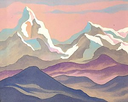

In [9]:
style_img_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/0/04/Tempera%2C_charcoal_and_gouache_mountain_painting_by_Nicholas_Roerich.jpg/301px-Tempera%2C_charcoal_and_gouache_mountain_painting_by_Nicholas_Roerich.jpg"
style_img = fetch_image(style_img_url)
style_img

In [10]:
with torch.no_grad():
    target_style = calc_styles(tfms.functional.to_tensor(style_img).unsqueeze(0).to(device))

## Training

In [11]:
def plot_loss(losses):
    plt.figure(figsize=(10,4))
    plt.plot(losses, '-', alpha=0.8)
    plt.title('Loss history (log10)')
    plt.show()

def plot_growth(nca, n=64):
    x = make_seed().to(device)
    img = torch.zeros(n, 3, IMAGE_SIZE, IMAGE_SIZE)
    for i in range(img.shape[0]):
        x = nca(x)
        img[i, :] = to_rgb(x).detach().cpu()

    imshow(make_grid(img, nrow=16).permute(1,2,0).numpy().clip(0,1), 
           figsize=(12,5), title="Growth")

def to_rgb(x):
    return x[...,:3,:,:] + 0.5

In [12]:
optimizer = torch.optim.Adam(nca.parameters(), 1e-3)
lr_sched = torch.optim.lr_scheduler.MultiStepLR(optimizer, [2000], 0.3)

loss_log = []
with torch.no_grad():
    pool = make_seed(1024).to(device)

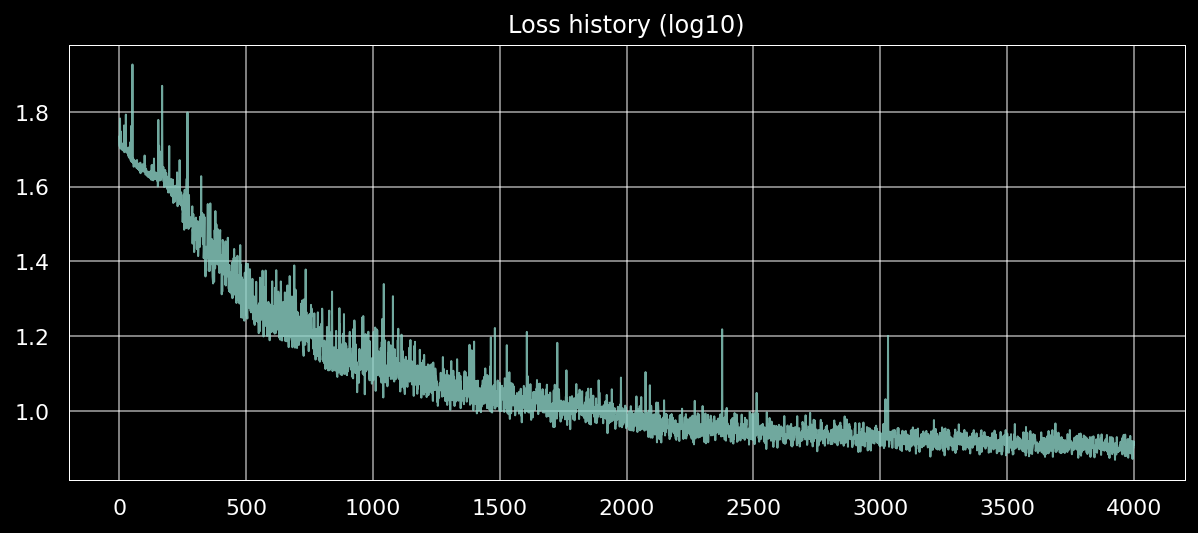

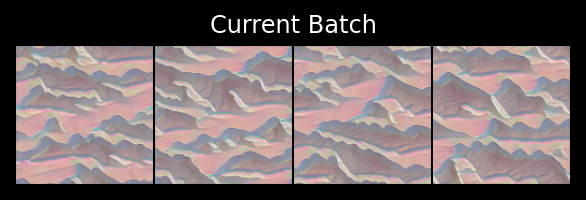

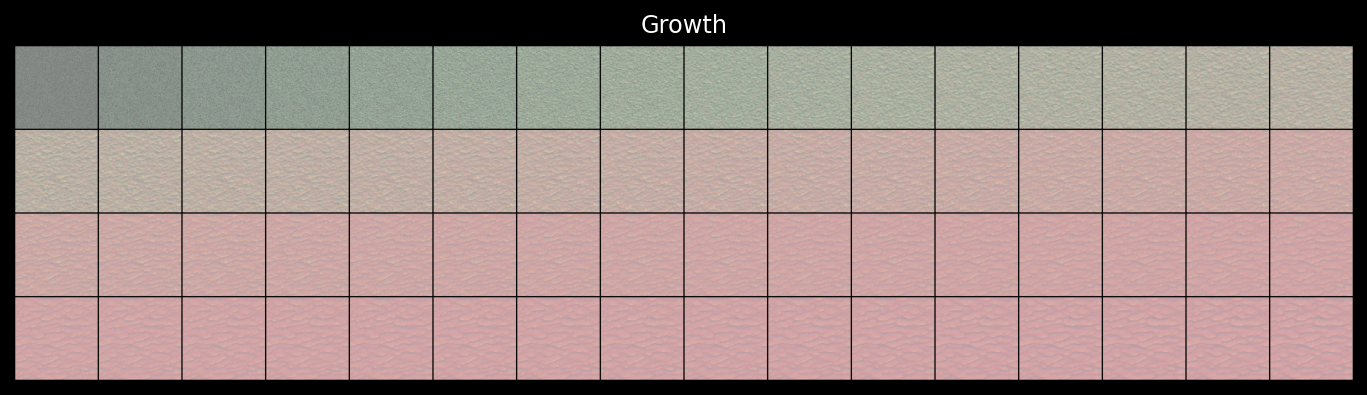

[4000/4001] elapsed: 1252s loss: 8.1118 lr: 0.0003

In [13]:
#@title Training loop {vertical-output: true}

epochs = 4001

start = time.time()

for epoch in range(epochs):
    with torch.no_grad():
        batch_idx = np.random.choice(len(pool), 4, replace=False)
        x = pool[batch_idx]
        if epochs % 2 == 0:
            x[:1] = make_seed().to(device)

    step_n = np.random.randint(32, 96)
    for k in range(step_n):
        x = nca(x)

    imgs = to_rgb(x)
    styles = calc_styles(imgs)
    loss = style_loss(styles, target_style)
    with torch.no_grad():
        loss.backward()
        for p in nca.parameters():
            p.grad /= p.grad.norm() + 1e-8

        optimizer.step()
        optimizer.zero_grad()
        lr_sched.step()

        pool[batch_idx] = x
        loss_log.append(loss.item())

        if epoch % 100 == 0:
            clear_output(True)
            plot_loss(np.log10(loss_log))
            imshow(make_grid(imgs.detach().cpu()).permute(1,2,0).clip(0,1).numpy(), 
                   title="Current Batch")
            plot_growth(nca)

        print("\r[{}/{}] elapsed: {}s loss: {:.4f} lr: {:.4f}".format(
            epoch, epochs, int(time.time() - start),
            loss.item(), lr_sched.get_lr()[0]), 
            end="")

In [15]:
#@title Growth {vertical-output: true}

x = make_seed().to(device)

def make_frame(t):
    global x
    x = nca(x)
    out = to_rgb(x.detach().cpu()[0]).permute(1,2,0).numpy().clip(0,1) * 255.0
    return out

animation = VideoClip(make_frame, duration=5)
animation.ipython_display(fps=60, loop=True, autoplay=True)

100%|█████████▉| 300/301 [00:00<00:00, 460.32it/s]
